### Same thing as simple_dk_test2, but this time with preferentially sampled data

This time, we will try to adjust for preferential sampling by changing the loss function.

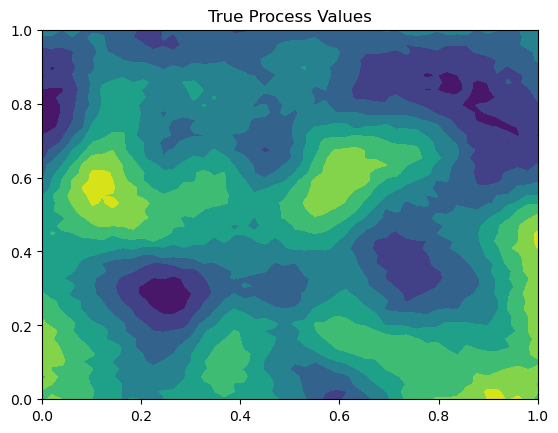

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from custom_dk_imports import DeepKrigingMLP
from custom_dk_imports import Trainer

np.random.seed(23)
torch.manual_seed(23)

N = 50
x = np.linspace(0, 1, N)
y = np.linspace(0, 1, N)
X, Y = np.meshgrid(x, y)
grid_points = np.vstack([X.ravel(), Y.ravel()]).T  # 2D coordinates

def exponential_kernel(s1, s2, length_scale):
    sqdist = np.sum(s1**2, axis=1).reshape(-1, 1) + np.sum(s2**2, axis=1) - 2 * np.dot(s1, s2.T)
    return np.exp(-0.5 * sqdist / length_scale**2)

length_scale = 0.1
cov_matrix = exponential_kernel(grid_points, grid_points, length_scale)
noise_var = 0.01  # Nugget variance
nugget = np.eye(grid_points.shape[0]) * noise_var
cov_matrix += nugget  # Covariance matrix with noise

mean = np.zeros(grid_points.shape[0])
process_values = np.random.multivariate_normal(mean, cov_matrix)

# Visualize the process values
process_values_grid = process_values.reshape(N, N)
plt.contourf(X, Y, process_values_grid)
plt.title("True Process Values")
plt.show()


In [2]:
# Define necessary parts from nn.py
class DeepKrigingEmbedding3d(nn.Module):
    def __init__(self, K: int):
        super(DeepKrigingEmbedding3d, self).__init__()
        self.K = K
        self.num_basis = [(9*2**(h-1)+1)**2 for h in range(1,self.K+1)]
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def forward(self, s: torch.Tensor) -> torch.Tensor:
        knots_1d = [torch.linspace(0, 1, int(np.sqrt(i))).to(self.device) for i in self.num_basis]
        N = s.shape[0]
        phi = torch.zeros(N, sum(self.num_basis)).to(self.device)
        K = 0
        for res, num_basis_res in enumerate(self.num_basis):
            theta = 1 / np.sqrt(num_basis_res) * 2.5
            knots_s1, knots_s2 = torch.meshgrid(knots_1d[res], knots_1d[res], indexing='ij')
            knots = torch.stack((knots_s1.flatten(), knots_s2.flatten()), dim=1).to(self.device)
            d = torch.cdist(s, knots) / theta
            mask = (d >= 0) & (d <= 1)
            weights = torch.zeros_like(d)
            weights[mask] = ((1 - d[mask]) ** 6 * (35 * d[mask] ** 2 + 18 * d[mask] + 3) / 3)
            phi[:, K:K + num_basis_res] = weights
            K += num_basis_res
        return phi

In [3]:
true_scaling = 2.0  # Example true scaling parameter
true_intercept = 0.0  # Example true intercept parameter

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x))

def preferential_sampling(points, values, n_samples=50):
    # define the likelihood of sampling a location as a function of its value
    probabilities = softmax(true_scaling*values + true_intercept)
    # Points with higher probabilities (derived from higher values) are more likely to be sampled
    sampled_indices = np.random.choice(len(points), size=n_samples, p=probabilities, replace=False)
    return points[sampled_indices], values[sampled_indices], sampled_indices

# Sample points from the grid preferentially
sampled_points, sampled_values, sampled_indices = preferential_sampling(grid_points, process_values, n_samples=200)

# from sklearn.model_selection import train_test_split
from custom_dk_imports import spatial_train_val_test_split
s_train, s_val, s_test, y_train, y_val, y_test = spatial_train_val_test_split(
    s=sampled_points, y=sampled_values, train_size=0.7, val_size=0.15, test_size=0.15, shuffle=True, block_sampling=False
)

# input_dim = 0  # Only want model to take in basis functions
num_hidden_layers = 1
hidden_dims = 100
K = 3  # Number of basis functions


# Instantiate the embedding layer
embedding_layer = DeepKrigingEmbedding3d(K)
input_dim = sum(embedding_layer.num_basis)  # This should match 1830

# Convert numpy arrays to torch tensors
s_train_tensor = torch.tensor(s_train, dtype=torch.float32)
s_val_tensor = torch.tensor(s_val, dtype=torch.float32)
s_test_tensor = torch.tensor(s_test, dtype=torch.float32)
s_all_tensor = torch.tensor(grid_points, dtype=torch.float32)

print(s_train_tensor)
embedding_layer.eval()
# Compute the basis functions for each split using the tensor inputs
phi_train = embedding_layer(s_train_tensor)
phi_val = embedding_layer(s_val_tensor)
phi_test = embedding_layer(s_test_tensor)
phi_all = embedding_layer(s_all_tensor)

# Convert y_train, y_val, and y_test to torch tensors
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

deepkriging_model = DeepKrigingMLP(input_dim, num_hidden_layers, hidden_dims, K=K, activation='relu')

train_loader = torch.utils.data.DataLoader(
    dataset=torch.utils.data.TensorDataset(phi_train, y_train),
    batch_size=32, shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    dataset=torch.utils.data.TensorDataset(phi_val, y_val),
    batch_size=32, shuffle=False
)

test_loader = torch.utils.data.DataLoader(
    dataset=torch.utils.data.TensorDataset(phi_test, y_test),
    batch_size=32, shuffle=False
)

data_generators = {'train': train_loader, 'val': val_loader, 'test': test_loader}

from custom_dk_imports import NewLoss
trainer = Trainer(
    model=deepkriging_model,
    data_generators={'train': train_loader, 'val': val_loader, 'test': test_loader},
    optim='adam',
    optim_params={'lr': 0.001},
    loss_fn=NewLoss(phi_train, phi_test, y_train), # CHANGE TO NEW LOSS TO CORRECT FOR PREFERENTIAL SAMPLING
    window_size=10,
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    epochs=100,
    patience=10
)

trainer.train()

deepkriging_model.eval()

with torch.no_grad():
    y_pred_deepkriging = deepkriging_model(phi_all).cpu().numpy()
    

tensor([[0.9592, 0.4082],
        [0.5918, 0.5306],
        [0.1224, 0.4898],
        [0.0816, 0.5510],
        [1.0000, 0.2245],
        [0.1224, 0.5714],
        [0.5714, 0.7959],
        [0.7551, 0.0816],
        [0.9184, 0.0000],
        [0.9796, 0.2245],
        [0.9796, 0.0612],
        [0.9592, 0.0204],
        [1.0000, 0.1633],
        [0.9796, 0.4082],
        [0.1633, 0.5918],
        [0.6531, 0.5510],
        [0.9184, 0.3265],
        [0.8163, 0.1633],
        [0.1429, 0.5102],
        [0.9796, 0.9184],
        [0.5306, 0.5102],
        [0.5918, 0.4898],
        [0.5918, 0.2857],
        [0.1020, 0.6531],
        [1.0000, 0.1429],
        [0.1837, 0.4898],
        [0.9388, 0.0204],
        [0.0408, 0.1224],
        [0.1224, 0.6122],
        [0.0204, 0.1020],
        [0.9796, 0.1429],
        [0.5918, 0.5918],
        [0.1429, 0.4286],
        [0.7143, 0.7551],
        [0.5918, 0.2041],
        [0.1429, 0.6735],
        [0.9388, 0.0000],
        [0.9184, 0.0204],
        [0.5

/Users/ellie/Desktop/CARLSON LAB/deep_ps/custom_dk_imports.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train = torch.tensor(X_train, dtype=torch.float32)
/Users/ellie/Desktop/CARLSON LAB/deep_ps/custom_dk_imports.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_test = torch.tensor(X_test, dtype=torch.float32)
/Users/ellie/Desktop/CARLSON LAB/deep_ps/custom_dk_imports.py:178: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train = torch.tensor(y_train, dtype=torch.float32)


Training started:

Epoch 1/100
Learning rate: 0.001000
0s for 5 steps - 16ms/step - loss 2.1463
Validation:
0s - loss 2.3283

Epoch 2/100
Learning rate: 0.001000
0s for 5 steps - 5ms/step - loss 1.9397
Validation:
0s - loss 2.1330

Epoch 3/100
Learning rate: 0.001000
0s for 5 steps - 4ms/step - loss 1.7249
Validation:
0s - loss 1.9490

Epoch 4/100
Learning rate: 0.001000
0s for 5 steps - 4ms/step - loss 1.5094
Validation:
0s - loss 1.7996

Epoch 5/100
Learning rate: 0.001000
0s for 5 steps - 2ms/step - loss 1.3116
Validation:
0s - loss 1.7097

Epoch 6/100
Learning rate: 0.001000
0s for 5 steps - 2ms/step - loss 1.1551
Validation:


/Users/ellie/Desktop/CARLSON LAB/deep_ps/custom_dk_imports.py:193: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1719361023382/work/aten/src/ATen/native/TensorShape.cpp:3679.)
  loss_1 = 0.5 * torch.matmul(torch.matmul(y_pred.T, self.K_inv_pt[:y_pred.shape[0], :y_pred.shape[0]]), y_pred) / y_pred.shape[0]


0s - loss 1.6867

Epoch 7/100
Learning rate: 0.001000
0s for 5 steps - 2ms/step - loss 1.0747
Validation:
0s - loss 1.6898

Epoch 8/100
Learning rate: 0.001000
0s for 5 steps - 2ms/step - loss 1.0287
Validation:
0s - loss 1.6824

Epoch 9/100
Learning rate: 0.001000
0s for 5 steps - 2ms/step - loss 1.0331
Validation:
0s - loss 1.6635

Epoch 10/100
Learning rate: 0.001000
0s for 5 steps - 2ms/step - loss 1.0500
Validation:
0s - loss 1.6489

Epoch 11/100
Learning rate: 0.001000
0s for 5 steps - 2ms/step - loss 1.0723
Validation:
0s - loss 1.6423

Epoch 12/100
Learning rate: 0.001000
0s for 5 steps - 2ms/step - loss 1.0998
Validation:
0s - loss 1.6408

Epoch 13/100
Learning rate: 0.001000
0s for 5 steps - 2ms/step - loss 1.1055
Validation:
0s - loss 1.6392

Epoch 14/100
Learning rate: 0.001000
0s for 5 steps - 2ms/step - loss 1.1047
Validation:
0s - loss 1.6357

Epoch 15/100
Learning rate: 0.001000
0s for 5 steps - 2ms/step - loss 1.0978
Validation:
0s - loss 1.6360

Epoch 16/100
Learning 

In [4]:
y_pred_deepkriging.shape

(2500, 1)

In [5]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

kernel = RBF(length_scale=0.1)
gp = GaussianProcessRegressor(kernel=kernel, alpha=noise_var)

gp.fit(s_train, y_train)   
y_pred_gp, y_std_gp = gp.predict(grid_points, return_std=True)

In [6]:
y_pred_deepkriging.shape

(2500, 1)

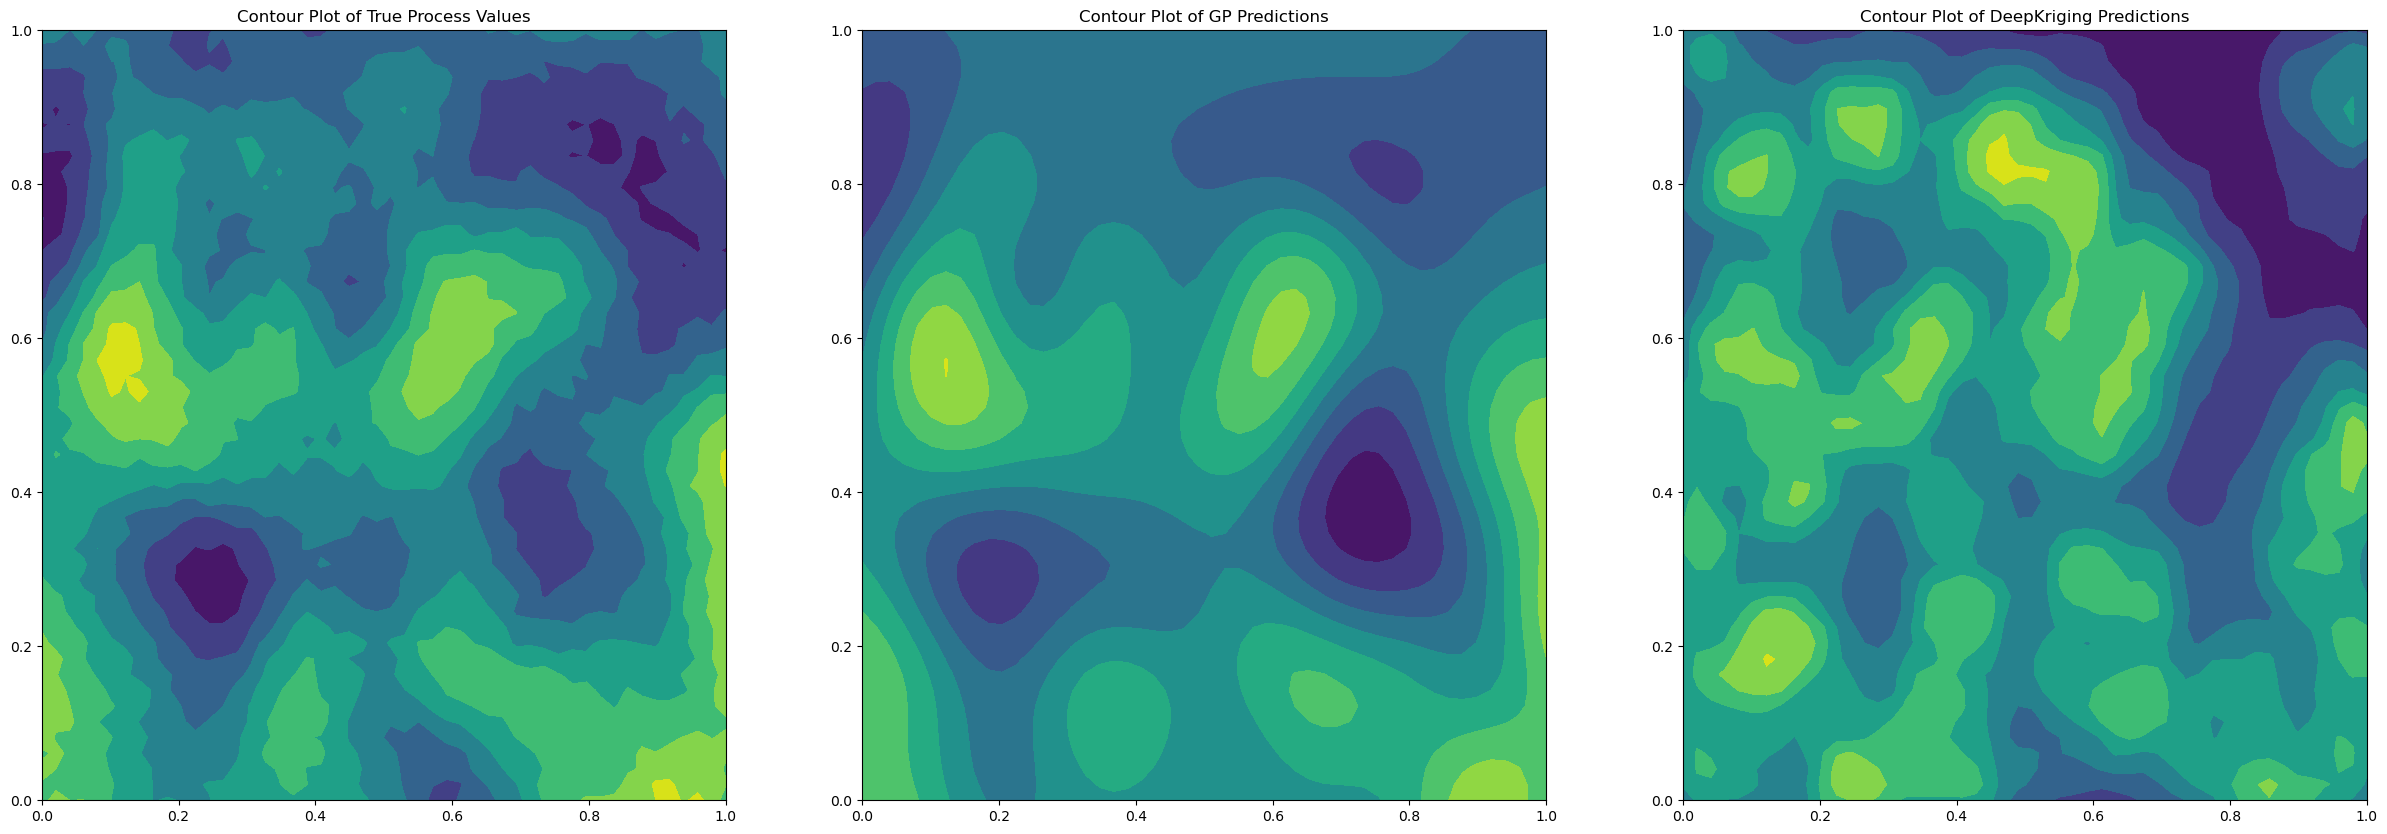

In [7]:
# from scipy.interpolate import griddata
import matplotlib.gridspec as gridspec

plt.figure(figsize=(30, 10))
gs = gridspec.GridSpec(1, 3)
ax = plt.subplot(gs[0, 0])
contour1 = ax.contourf(X, Y, process_values_grid, cmap='viridis')
ax.set_title("Contour Plot of True Process Values")

ax = plt.subplot(gs[0, 1])
# # Plot DeepKriging predictions directly on the test points
contour2 = ax.contourf(X, Y, y_pred_gp.reshape(*X.shape), cmap='viridis')
ax.set_title("Contour Plot of GP Predictions")

ax = plt.subplot(gs[0, 2])
# # Plot GP predictions directly on the test points
contour3 = ax.contourf(X, Y, y_pred_deepkriging.reshape(*X.shape), cmap='viridis')
ax.set_title("Contour Plot of DeepKriging Predictions")


# fig.colorbar(contour1, ax=ax)

plt.show()

# Something appears to be off with the NewLoss, which we were planning to use to correct for preferential sampling.

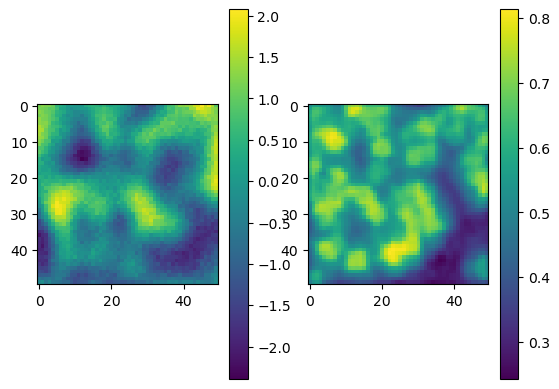

In [8]:
# fig, (ax1, ax2) = plt.subplots(1,2)
plt.subplot(1,2,1)
plt.imshow(process_values_grid)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(y_pred_deepkriging.reshape((50,50)))
plt.colorbar()


In [9]:
np.mean((process_values_grid - y_pred_deepkriging.reshape((50, 50)))**2)

np.float64(1.2369189519740011)

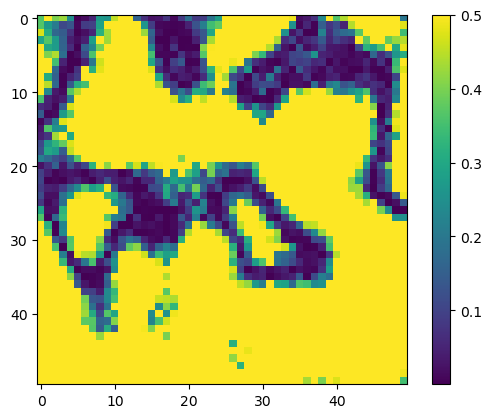

In [10]:
error = (process_values_grid - y_pred_deepkriging.reshape(*X.shape))**2

plt.imshow(error, vmax=0.5)
plt.colorbar()

In [11]:
with torch.no_grad():
    y_pred_deepkriging = deepkriging_model(phi_test).cpu().numpy()

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate RMSE and MAPE for DeepKriging (Model 2)
rmse_deepkriging = rmse(y_test.numpy(), y_pred_deepkriging)
mape_deepkriging = mape(y_test.numpy(), y_pred_deepkriging)
print(f"RMSE (DeepKriging): {rmse_deepkriging}")
print(f"MAPE (DeepKriging): {mape_deepkriging}")

# Calculate RMSE and MAPE for Basic GP
rmse_gp = rmse(y_test.numpy(), y_pred_gp)
mape_gp = mape(y_test.numpy(), y_pred_gp)
print(f"RMSE (GP): {rmse_gp}")
print(f"MAPE (GP): {mape_gp}")

# MSE is now pretty high... :(((

RMSE (DeepKriging): 0.579197347164154
MAPE (DeepKriging): 45.91476058959961
RMSE (GP): 1.2818876947015323
MAPE (GP): 120.13222221894144
